In [106]:
import scipy.io as sio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [107]:
learning_rate = 1e-4
Input_sqr = 24 ## Change this when you chane the size of covariance.
channel = 2
n_labels = 5 ## change it to number of area
keep_prob = 0.5

num_epochs = 50 ## number of epoch
num_batches = 64 ## size of batch, depend on your GPU memory

In [108]:
## training dataset initialize

string_input1 = '/content/drive/MyDrive/nctu/AiLab_Final/train_dataset_24by24/train_Covariance'
string_input2 = 'Covariance'
string_output1 = '/content/drive/MyDrive/nctu/AiLab_Final/train_dataset_24by24/train_Label'
string_output2='Label'
    
#input    size: (data_num,Input_sqr,Input_sqr,channel)
mat = sio.loadmat(string_input1)
train_input = mat[string_input2]
train_input = np.float32(train_input)
#output    size: (data_num,1)
mat = sio.loadmat(string_output1)
train_output = mat[string_output2]       
train_output = np.float32(train_output)

## test dataset initialize
string_input3 = '/content/drive/MyDrive/nctu/AiLab_Final/test_dataset_24by24/test_Covariance'
string_input4 = 'Covariance'
string_output3 = '/content/drive/MyDrive/nctu/AiLab_Final/test_dataset_24by24/test_Label'
string_output4 = 'Label'
    
#input    size: (data_num,Input_sqr,Input_sqr,channel)
mat = sio.loadmat(string_input3)
test_input = mat[string_input4]
test_input = np.float32(test_input)

#output    size: (data_num,1)
mat = sio.loadmat(string_output3)
test_output = mat[string_output4]       
test_output = np.float32(test_output)

In [114]:
## Define model ##
## you can choose your lose at Line71 ##
# model = models.Sequential([
#     layers.Conv2D(64, (3, 3), activation='relu', input_shape=(Input_sqr, Input_sqr, channel)),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, (3, 3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(256, (3, 3), activation='relu'),
#     layers.BatchNormalization(),
#     layers.MaxPooling2D((2, 2)),
#     layers.Flatten(),
#     layers.Dense(512, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(256, activation='relu'),
#     layers.Dense(n_labels, activation='softmax')
# ])

model = models.Sequential([
    layers.Conv2D(64, (2, 2), input_shape=(Input_sqr, Input_sqr, channel)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (2, 2)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256),
    layers.Dropout(0.5),
    layers.Dense(400),
    layers.Dense(200),
    layers.Dense(n_labels, activation='softmax')
])


print(model.summary())
## compile and train the model ##

Adam = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=Adam,
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']) 
    # maybe use loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
# model.compile(optimizer=Adam,
#               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy']) 
## end of Define model ##

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_31 (Conv2D)          (None, 23, 23, 64)        576       
                                                                 
 batch_normalization_17 (Bat  (None, 23, 23, 64)       256       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 10, 10, 64)        16448     
                                                                 
 batch_normalization_18 (Bat  (None, 10, 10, 64)       256       
 chNormalization)                                                
                                                     

None


In [110]:
## Callback setting ##
## Callback 可用可不用，若不需使用請在model.fit中刪去callbacks ##

# class CustomCallback(tf.keras.callbacks.Callback): # you can custom your callback like this
#     def on_epoch_end(self, epoch, logs=None):
#         if epoch%5 == 0:
#             print('epoch:%d, loss:%f' %(epoch,logs.get('loss')))

## the following is create a folder to save checkpoint
ckpt_folder = "./ckpt"
if not os.path.exists(ckpt_folder):
    os.mkdir(ckpt_folder)
## here is the checkpoint callback, it will save the weight of best val_accuracy
## We will load_weight after training (at Line148 load best weight to evaluate test_dataset)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckpt_folder,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

## it is EarlyStopping, if your model not improve performace in "patience" epoch, it will stop
model_StopEarly_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.005,    ## it can decide by you
    patience=10,        ## it can decide by you
    verbose=0,
    mode='max',
    baseline=None,
    restore_best_weights=False,
)

## end of Callback setting ##

In [111]:
# start to train model ##
# train_history = model.fit(train_input, train_output,batch_size=num_batches, epochs=num_epochs,
#                           validation_data=(test_input, test_output), 
#                           callbacks=[model_checkpoint_callback, model_StopEarly_callback])
train_history = model.fit(train_input, train_output,batch_size=num_batches, epochs=num_epochs,
                          validation_data=(test_input, test_output))


Epoch 1/50
200/200 [==============================] - 19s 88ms/step - loss: 1.1085 - accuracy: 0.6836 - val_loss: 1.6000 - val_accuracy: 0.5453
Epoch 2/50
200/200 [==============================] - 19s 93ms/step - loss: 0.4514 - accuracy: 0.8361 - val_loss: 1.3744 - val_accuracy: 0.6391
Epoch 3/50
200/200 [==============================] - 19s 94ms/step - loss: 0.3212 - accuracy: 0.8869 - val_loss: 1.8110 - val_accuracy: 0.6578
Epoch 4/50
200/200 [==============================] - 18s 88ms/step - loss: 0.2415 - accuracy: 0.9195 - val_loss: 1.5489 - val_accuracy: 0.6930
Epoch 5/50
200/200 [==============================] - 18s 91ms/step - loss: 0.2377 - accuracy: 0.9236 - val_loss: 2.2107 - val_accuracy: 0.6609
Epoch 6/50
200/200 [==============================] - 20s 98ms/step - loss: 0.1604 - accuracy: 0.9466 - val_loss: 1.0717 - val_accuracy: 0.7695
Epoch 7/50
200/200 [==============================] - 19s 95ms/step - loss: 0.1314 - accuracy: 0.9554 - val_loss: 1.2357 - val_accuracy:

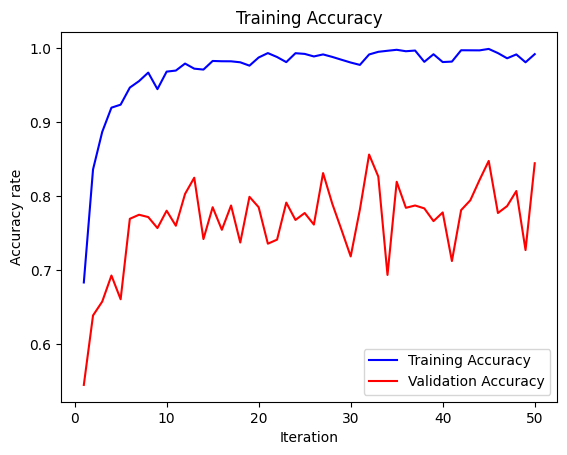

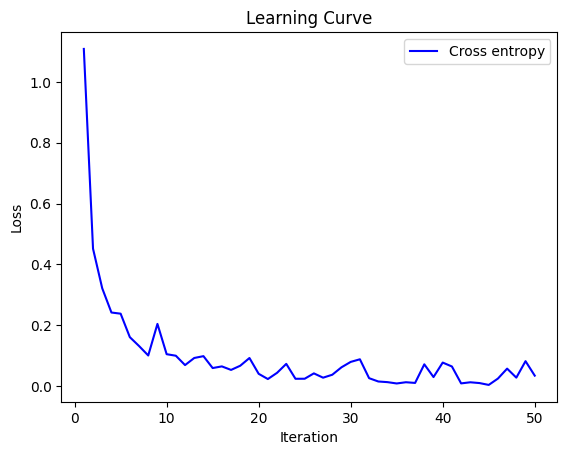

In [112]:
# plot Accuracy ##

history_dict = train_history.history
plt.figure(1)
plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy rate')
plt.legend(loc='lower right')

## plot loss
loss = history_dict['loss']
epochs = range(1, len(loss)+1)
plt.figure(2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Learning Curve')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend(['Cross entropy'], loc='upper right')
plt.show()

## end of plot Accuracy ##

In [113]:
## evaluate loss value of test dataset ##

# model.load_weights(ckpt_folder)
test_loss = model.evaluate(test_input, test_output)
print("test loss:", test_loss)

## end of evaluate loss value of test dataset ##

40/40 [==============================] - 1s 10ms/step - loss: 1.3314 - accuracy: 0.8445
test loss: [1.3314197063446045, 0.844531238079071]
